<h1><center> Reflectometry simulations performance - Reusing an already performing engine </center></h1>

In this notebook, a naïve approach is taken to assess the feasibility of extracting the computing engine from Refnx and embed it *somewhere else*. In this particular case, the computatinal engine of Refnx was embedded into a single-purpose python api developed from scratch. The new [SWIG](http://www.swig.org/) api was put to the following tests for the [Ti-Ni bilayer model](https://www.bornagainproject.org/documentation/working-with-python/basic-simulation-tutorial/reflectometry/):

 - Time scaling with the number of layers
 - Time taken to run a simple simulation
 - Time scaling with the simulation resolution

The accuracy of the results was demonstrated by comparison with results obtained by BornAgain and the timings were compared to the timings obtained using Refnx.

In [1]:
%reset -f
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def theta_to_q(theta, wavelength = 1.0):
    return 4.0 * np.pi * np.sin(theta*np.pi/180.0) / wavelength

def q_to_theta(qvec, wavelength = 1.0):
    return 180.0 * np.arcsin( wavelength * qvec / (4.0*np.pi) ) / np.pi

def plot_timings_comparison(timings_a, timings_b, x_label):
    FigSize = 7
    FontSize = 20
    BorderWidth = 3
    plt.rcParams.update({'font.size': FontSize})
    plt.rcParams.update({'axes.linewidth': BorderWidth})    
    plt.figure(figsize=(FigSize,FigSize))
    plt.plot(timings_a[:,0], timings_a[:,1], 'o-',label = "Refnx")
    plt.plot(timings_b[:,0], timings_b[:,1], 'o-',label = "Reflectawesometry")
    plt.legend()
    plt.grid()
    plt.ylabel("$t \, [s]$")
    plt.xlabel(x_label)

In [3]:
# Bornagain modules:
import bornagain as ba

def ba_reflectivity(multilayer,theta_vals):
    wavelength = 1.0 * ba.angstrom
    simulation = ba.SpecularSimulation()
    simulation.setBeamParameters(wavelength, theta_vals * ba.deg)
    simulation.setSample(multilayer)
    simulation.getOptions().setNumberOfThreads(1)
    simulation.runSimulation()
    results = simulation.result()
    simulation_data = results.data()
    return simulation_data.getArray()

def run_ba_model(num_bilayers,theta_vals):
    # creating materials
    m_ambient = ba.MaterialBySLD("Ambient", 0.0, 0.0)
    m_ti = ba.MaterialBySLD("Ti", -2.0e-06, 0.0)
    m_ni = ba.MaterialBySLD("Ni", 10.0e-06, 0.0)
    m_substrate = ba.MaterialBySLD("SiSubstrate", 2.07e-06, 0.0)
    
    # creating layers
    ambient_layer = ba.Layer(m_ambient)
    ti_layer = ba.Layer(m_ti, 30 * ba.angstrom)
    ni_layer = ba.Layer(m_ni, 70 * ba.angstrom)
    substrate_layer = ba.Layer(m_substrate)
    
    # creating the multilayer
    ti_ni_multilayer = ba.MultiLayer()
    
    ti_ni_multilayer.addLayer(ambient_layer)
    for i in range(num_bilayers):
        ti_ni_multilayer.addLayer(ti_layer)
        ti_ni_multilayer.addLayer(ni_layer)
    ti_ni_multilayer.addLayer(substrate_layer)
    
    
    reflectivity_values = ba_reflectivity(ti_ni_multilayer,theta_vals)
    
    return reflectivity_values

In [4]:
# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

def refnx_reflectivity(structure,qvals):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(qvals)

def run_refnx_model(num_bilayers,qvals):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
    sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
    slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(num_bilayers):
        structure.append(slab_Ti)
        structure.append(slab_Ni)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

## The new module is called *Reflectawesometry*...
...to highlight by contrast that it is nothing *awesome*. The module has only one function that calculates the reflectometry of the Ti-Ni multilayer model.

In [5]:
# The only thing inside this module is the function run_my_model, 
# which runs the "N stacked Ti-Ni bilayers" model
from Reflectawesometry import run_my_model

# 0. Test the accuracy of the calculations with respect to BornAgain:

In [6]:
qvals = np.linspace(0.0,0.5,1025)
theta = q_to_theta(qvals)

#Reflectometry calculated by Bornagain:
reflectometry = run_ba_model(10,theta)

#Reflectometry calculated by the refnx engine:
reflectawmetry = run_my_model(10,qvals)

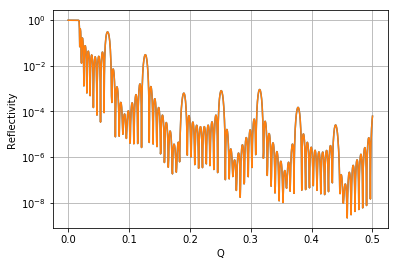

In [7]:
plt.semilogy(qvals,reflectometry)
plt.semilogy(qvals,reflectawmetry)
#plt.xticks([qvals[0],qvals[-1]])
plt.xlabel("Q")
plt.ylabel("Reflectivity")
plt.grid()

# Check that the errors are of the order of $10^{-10}$

We already know that [Refnx and BornAgain, for the Ti-Ni bilayer model, provide the same results](https://nbviewer.jupyter.org/github/juanmcloaiza/BornAgainReflectometryComparison/blob/master/LipidBilayerSimulation-Refnx-BA/Towards_the_Lipid_Bilayer_Model.ipynb) with an accuracy of $10^{-10}$. The question is: Does this hold true for the new *awesome* api? --Yes, it does:

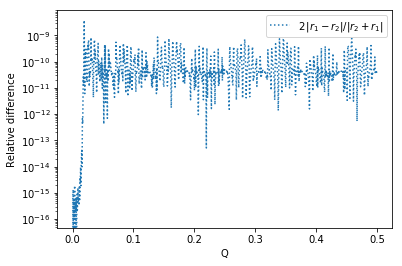

In [8]:
plt.semilogy(qvals, 2.0 * np.abs(reflectometry-reflectawmetry)/np.abs(reflectometry+reflectawmetry), ':', 
            label = "$2 \, |r_{1} - r_{2}|/|r_{2} + r_{1}|$")
plt.xlabel("Q")
plt.ylabel("Relative difference")
plt.legend()
plt.show()

# Time scaling with the number of Ti-Ni bilayers
We already know from [another analysis](https://nbviewer.jupyter.org/github/juanmcloaiza/BornAgainReflectometryComparison/blob/master/PerformanceTests/BornAgain_Performance_Analysis.ipynb) that BornAgain has an $O(N^2)$ time-scaling, while Refnx scales as $O(N)$; What would be nice to show is that the bare Refnx computation engine embeded in the new *awesome* api not only scales as $O(N)$ but the computation time is also lower than that of Refnx.

The time-scaling of the *awesome* api is $O(N)$, as expected --it would be really strange if this were not the case. Sadly, even the bare computation engine is slower than Refnx. Why? The bare computation engine is using `std::vector`s to interface with the *awesome* api in places where refnx is using bare arrays and pointer arithmetics, which is a more efficient way to go in demanding computational tasks. That *may* be the reason.

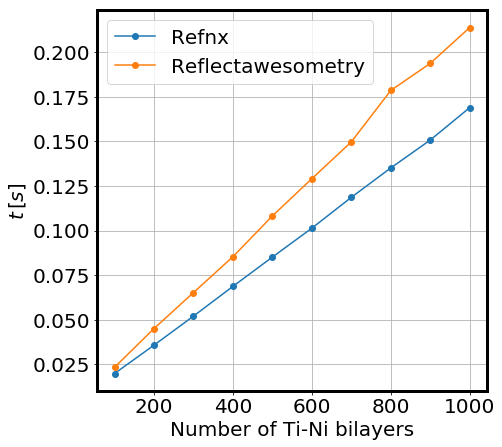

In [9]:
ba_t = []
aw_t = []
rfnx_t = []
for n_bilayers in [100,200,300,400,500,600,700,800,900,1000]:    
    aw_t0 = time.time()
    run_my_model(n_bilayers,qvals)
    aw_tf = time.time()
    aw_t.append([n_bilayers, aw_tf-aw_t0])    
    
    rfnx_t0 = time.time()
    run_refnx_model(n_bilayers,qvals)
    rfnx_tf = time.time()
    rfnx_t.append([n_bilayers, rfnx_tf-rfnx_t0])    
    
ba_t = np.asarray(ba_t)
aw_t = np.asarray(aw_t)
rfnx_t = np.asarray(rfnx_t)
plot_timings_comparison(rfnx_t,aw_t,"Number of Ti-Ni bilayers")

# How many times is the *awesome* api slower than Refnx?

The *awesome* api is slower than Refnx between 1.10 and 1.3 times.

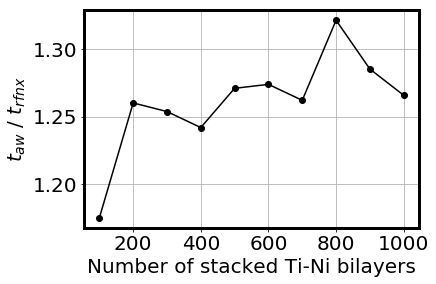

In [10]:
plt.plot(aw_t[:,0],aw_t[:,1]/rfnx_t[:,1], 'ko-')

plt.xlabel("Number of stacked Ti-Ni bilayers")
plt.ylabel("$t_{aw}$ / $t_{rfnx}$")

plt.grid()

# Is this due to multithreading?

Check with `top` that no more than 100% CPU is used:

### BornAgain:

In [11]:
dummy_ref = run_ba_model(1000,theta)

Sample output of `top` command (`%CPU` column is no more than 100%):
```
  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
[...]
24474 juan      20   0 1575596 151064  46436 R  26,9  0,5   1:06.94 python3.5
24474 juan      20   0 1581060 156064  46436 R 100,0  0,5   1:09.95 python3.5
24474 juan      20   0 1581060 156064  46436 R 100,3  0,5   1:12.96 python3.5
24474 juan      20   0 1581060 156064  46436 R 100,0  0,5   1:15.97 python3.5
24474 juan      20   0 1581060 156064  46436 R 100,0  0,5   1:18.98 python3.5
24474 juan      20   0 1581060 156064  46436 R 100,3  0,5   1:21.99 python3.5
[...]
```

### Refnx:

In [12]:
dummy_ref = run_refnx_model(20000,qvals)

Sample output of `top` command (`%CPU` column is no more than 100%):
```
  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
[...]
25500 juan      20   0 1663824 165000  46452 R 100,0  0,5   0:59.32 python3.5
25500 juan      20   0 1663824 165000  46452 R 106,2  0,5   0:59.49 python3.5
25500 juan      20   0 1663824 165000  46452 R 100,0  0,5   0:59.63 python3.5
25500 juan      20   0 1663824 165000  46452 R 100,0  0,5   0:59.78 python3.5
25500 juan      20   0 1663824 165000  46452 R  99,7  0,5   1:02.78 python3.5
25500 juan      20   0 1663824 165000  46452 R 100,3  0,5   1:05.79 python3.5
25500 juan      20   0 1663824 165000  46452 R 100,0  0,5   1:08.80 python3.5
[...]
```

### *Awesome* api:

In [13]:
dummy_ref = run_my_model(20000,qvals)

Sample output of `top` command (`%CPU` column is no more than 100%):
```
  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
[...]
25500 juan      20   0 1658392 159924  46452 R 104,5  0,5   1:51.65 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R  95,5  0,5   1:51.86 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R 100,0  0,5   1:52.09 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R 100,0  0,5   1:52.30 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R 100,0  0,5   1:52.68 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R 100,0  0,5   1:53.01 python3.5                                                                                                                                                  
25500 juan      20   0 1658392 159924  46452 R 100,0  0,5   1:53.31 python3.5                                                                                                                                                                                                                                                                                                   
25500 juan      20   0 1658392 159924  46452 S 103,0  0,5   1:54.56 python3.5 
[...]
```

# Conclusions

This notebook and the code attached to it (Reflectawesometry) provided both a pedagogical excercise and a measure of the effort required to take a computing engine from *one place* and embedding it on *another place*.